In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from pybedtools import BedTool

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

from scipy.spatial.distance import pdist, squareform

import numpy as np
from scipy import stats
import matplotlib.cm as cm
import matplotlib
import math
from plot_params import *
basedir= Path('/tscc/nfs/home/hsher/scratch/ABC_2rep/')
out_stem = 'K562_rep6'

In [2]:
ground_truth = pd.read_csv('Dan_multiplex1_K562_rep4.Dan_multiplex1_K562_rep6.reproducible_window.csv',
                          index_col = 0)
clipper_1rep = pd.read_csv(f'Dan_multiplex1_{out_stem}.window.csv')
ground_truth_skipper = pd.read_csv('ABC_K562.skipper_reproducible_window.csv',
                          index_col = 0)
ground_truth_skipper.rename({'DDX3X':'DDX3'}, axis = 1, inplace = True)
ground_truth_skipper.sum().sort_values()

EIF3G         213
ZC3H11A      4722
PUM2         7147
RBFOX2      12206
DDX3        12334
LIN28B      26668
IGF2BP2     28834
SF3B4       44025
FAM120A     50622
PRPF8      102243
dtype: int64

In [3]:
data = pd.read_csv(basedir/f'DMM/{out_stem}.mixture_weight.tsv', sep = '\t', index_col = 0)
data.set_index('Row.names', inplace = True)

In [4]:
mixture_weight_only = data.loc[:, data.columns.str.startswith('V')]
mixture_weight_only.columns
data['cluster']=mixture_weight_only.idxmax(axis = 1)

In [5]:
mapstat = pd.read_csv(basedir/'QC/mapping_stats.csv')
mapstat = mapstat.loc[mapstat['STAR Log filename'].str.contains(out_stem)]
mapstat['name'] = mapstat['STAR Log filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
mapstat.set_index('name', inplace = True)
mapstat['total_mapped_reads'] = mapstat['Uniquely mapped reads number']+mapstat['Number of reads mapped to multiple loci']

In [6]:
raw_data = pd.read_csv(basedir /f'counts/genome/megatables/{out_stem}.tsv.gz', sep = '\t')
raw_data = raw_data.loc[raw_data.sum(axis = 1)>10]
raw_data.index = raw_data.index+1

In [7]:

weights = pd.read_csv(basedir/f'DMM/{out_stem}.weights.tsv', sep = '\t', index_col = 0)
weights.index = [f'V{i}' for i in weights.index]

In [8]:
megaoutput = pd.read_csv(basedir/f'DMM/{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)

In [9]:
anno = pd.read_csv(basedir/f'DMM/{out_stem}.cluster_annotation_binary.csv',
                          index_col = 0) # RBP by components, B * K

In [10]:
# apply mask to BBM, skipper and Piranha in place, not integrated into pipeline yet
mask = pd.read_csv(basedir / f'mask/{out_stem}.genome_mask.csv', index_col = 0) 
mask.columns = [c.split('.')[1] for c in mask.columns]

# Reviewer 1 wants to know how many RBP combinatinos

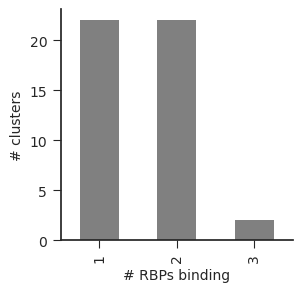

In [11]:
anno.sum(axis = 1).value_counts().sort_index().plot.bar(color = 'grey', figsize = (3,3))
plt.ylabel('# clusters')
plt.xlabel('# RBPs binding')
sns.despine()

# Comparing binding site counts
- different algorithm
- different backgrounds

In [12]:
# initial published data
clipper_counts = pd.read_csv(f'Dan_multiplex1_{out_stem}.window.feature_counts.csv', index_col = 0).T
clipper_counts['name']='CLIPper+CC'
clipper_counts['RBP']=clipper_counts.index
# eCLIP reproducible windows
eclip_counts = pd.read_csv('ABC_K562.skipper_reproducible_window.feature_counts.csv', index_col = 0).T
eclip_counts.rename({'DDX3X':'DDX3'}, inplace = True)
eclip_counts['name']='eCLIP'
eclip_counts['RBP']=eclip_counts.index

In [13]:
def count_beta_mixture(root_dir, name):
    all_counts = []
    for fname in list(root_dir.glob(f'{out_stem}*enriched_windows.tsv')):
        libname, rbp = fname.name.split('.')[:2]
        df = pd.read_csv(fname, index_col = 0, sep = '\t')
        to_mask = mask.loc[~mask[f'{rbp}']].index # False mean the deviation zscore is not high enough
        df = df.loc[~df['name'].isin(to_mask)]
        cnt = df['feature_type_top'].value_counts()
        cnt['RBP'] = rbp

        all_counts.append(cnt)
    all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index().T
    
    all_counts['name']=name
    return all_counts

In [14]:
def get_piranha_count(root_dir, name):
    count = []
    for f in list(root_dir.glob(f'{out_stem}*')):
        piranha_df = pd.read_csv(f, names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
        rbp = f.name.split('.')[1]
        to_mask = mask.loc[~mask[f'{rbp}']].index
        piranha_df['feature_type_top']=piranha_df['name'].map(data['feature_type_top'])
        cnt = piranha_df.loc[~piranha_df['name'].isin(to_mask), 'feature_type_top'].value_counts()
        cnt['RBP'] = rbp
        count.append(cnt)
    count = pd.concat(count, axis = 1).T
    
    count['name']=name
    return count

In [15]:
def get_skipper_count(root_dir, name):
    reg_col = ['CDS', 'INTRON', 'UTR3', 'UTR5', 'CDS_START', 'SS5_PROX', 'EXON_LNCRNA',
       'EXON_MRNA', 'CDS_STOP', 'SS5_ADJ', 'SS3_PROX', 'EXON_SMALL',
       'SSB_PROX', 'SS3_ADJ', 'PRIMIRNA', 'EXON_PSEUDO', 'SSB_ADJ',
       'CDS_SOLITARY']
    counts = []
    for paths in (root_dir/'enriched_windows').glob(f'{out_stem}.*enriched_windows*'):
        df = pd.read_csv(paths, sep='\t')
        rbp = paths.name.split('.')[1]
        to_mask = mask.loc[~mask[f'{rbp}']].index
        
        # filter for significant
        df = df.loc[~df['name'].isin(to_mask)]
        region_count = df['feature_type_top'].value_counts()
        region_count['RBP']=paths.name.split('.')[1]
        
        counts.append(region_count)
    counts = pd.concat(counts, axis = 1).fillna(0).T
    
    counts['name']=name
    return counts


In [16]:
rename_dict = {'K562_totalRNAseq': 'totalRNAseq',
               'eCLIP_SLBP_SMInput': 'eCLIP_SMInput', 
                       'oligoCLIP_IgG_rep1': 'Barcode-IgG', 
               'oligoCLIP_ctrlBead_rep1': 'Bead-only control',
                       'oligoCLIP_ctrlSpike_rep1':'Spike-in'
              }

In [17]:
all_counts = [eclip_counts,
              count_beta_mixture((basedir/'DMM'), 'DMM'),
              count_beta_mixture((basedir/'beta-mixture_CC'), 'BBM+CC'),
              clipper_counts,
              get_skipper_count(basedir/'skipper_CC', 'Skipper+CC'),
              get_piranha_count(basedir/'comparison'/'piranha'/'CC', 'Piranha+CC'),
              get_piranha_count(basedir/'comparison'/'piranha'/'nobg', 'Piranha(no bg)')
              
             ]
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    renamed_bg_name = rename_dict[ext_background]
    all_counts.append(count_beta_mixture(basedir/f'beta-mixture_external/{ext_background}', 
                                         f'BBM+{renamed_bg_name}'))
    
    all_counts.append(get_skipper_count(basedir/'skipper_external'/ext_background, 
                                        f'skipper+{renamed_bg_name}'))
all_counts = pd.concat(all_counts, axis = 0).T.sort_index().T


In [18]:
def plot_feature_type_barplots(all_counts):
    sns.set_palette('tab20c')
    f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
    axes = axes.flatten(order = 'C')
    i = 0
    for rbp, group in all_counts.groupby(by = 'RBP'):
        group.set_index('name').plot.barh(stacked = True, ax = axes[i], legend = False)
        axes[i].set_title(rbp)
        if i>=5:
            axes[i].set_xlabel('Number enriched windows')
        i+=1
    axes[-1].legend(bbox_to_anchor = (1, -0.3), ncol = 5)
    sns.despine()
    plt.tight_layout(pad = 1)
    plt.subplots_adjust(
                        hspace=0.4)



In [19]:
def plot_ascertained_feature(counts):
    f, axes = plt.subplots(2,5, figsize = (10,4), sharey = True)
    axes = axes.flatten()

    feature = {'SF3B4': 'SS3', 
               'IGF2BP2': 'UTR3', 
               'RBFOX2': 'INTRON', 
               'EIF3G': 'UTR5', 
               'FAM120A': 'UTR3', 
               'DDX3': 'UTR5', 
               'LIN28B': 'UTR3',
               'PUM2': 'UTR3', 
               'PRPF8': 'SS5', 
               'ZC3H11A': 'UTR3'
              }
    truth_count = []
    for i, (rbp, ax) in enumerate(zip(counts['RBP'].unique(), axes)):
        feat = feature[rbp]
        presumed_truth = counts.loc[counts['RBP']==rbp].set_index('name')[counts.columns[counts.columns.str.contains(feat)]
                                                          ].sum(axis = 1)
        presumed_truth.plot.barh(ax = ax, color = 'Grey')
        ax.set_title(f'{rbp}:{feat}')
        if i>=5:
            ax.set_xlabel('Number enriched windows')
        i+=1

        presumed_truth.name = rbp
        truth_count.append(presumed_truth)
    truth_count = pd.concat(truth_count, axis = 1)
    sns.despine()
    plt.tight_layout(pad = 1)
    plt.subplots_adjust(
                        hspace=0.4)

/tmp/ipykernel_2258679/3475999329.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad = 1)


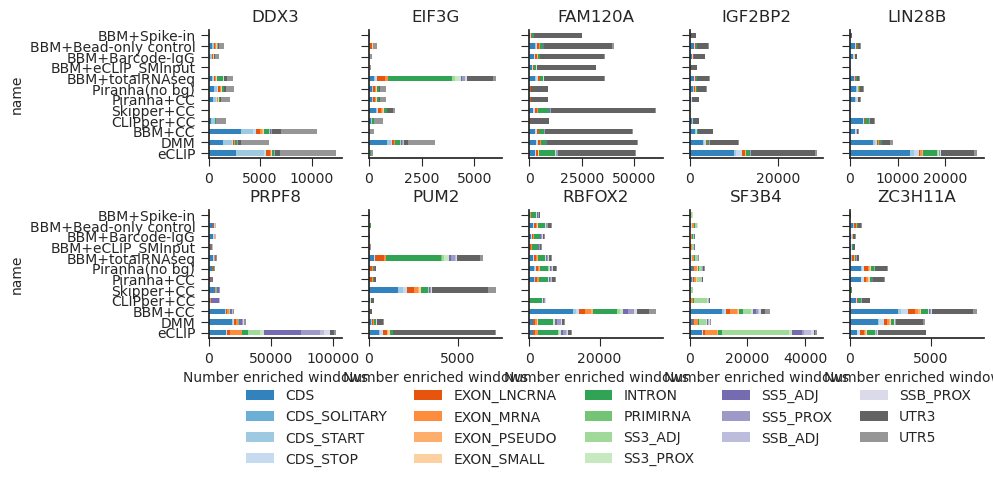

In [20]:
plot_feature_type_barplots(all_counts.loc[#(all_counts['name'].str.contains('BBM'))|
                                         (all_counts['name'].str.contains('DMM')) |
                                        (all_counts['name'].str.contains('BBM')) |
                                        (all_counts['name']=='eCLIP') |
                                        (all_counts['name']=='CLIPper+CC') |
                                        (all_counts['name']=='Skipper+CC') |
                                        (all_counts['name']=='Piranha+CC') |
                                       (all_counts['name']=='Piranha(no bg)')
                                         ])
plt.savefig(figdir/f'feature_bar.pdf')

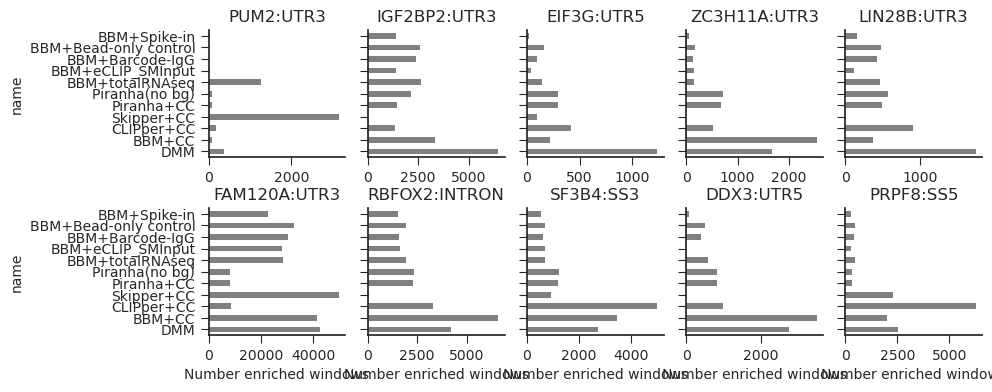

In [21]:
plot_ascertained_feature(all_counts.loc[(all_counts['name'].str.contains('DMM')) |
                                        (all_counts['name'].str.contains('BBM')) |
                                        
                                        (all_counts['name']=='CLIPper+CC') |
                                        (all_counts['name']=='Skipper+CC') |
                                        (all_counts['name']=='Piranha+CC') |
                                         (all_counts['name']=='Piranha(no bg)')
                                         ])
plt.savefig(figdir/f'Ascertained_feature.pdf')

# Compare binding site classification to eCLIP
## Read all scores


In [22]:
all_scores = {}

In [23]:
def get_mixture_score_by_rbp(cluster_assignment_df,data):
    ''' sum up mixture score by belonging to a RBP or not '''
    mixture_score_by_rbp = []
    for rbp in cluster_assignment_df:
        clusters_belong_to_rbp = cluster_assignment_df[rbp].loc[cluster_assignment_df[rbp]].index
        rbp_score = data[clusters_belong_to_rbp].sum(axis = 1)
        rbp_score.name = rbp.split('.')[1]
        mixture_score_by_rbp.append(rbp_score)
    mixture_score_by_rbp = pd.concat(mixture_score_by_rbp, axis = 1)
    return mixture_score_by_rbp

In [24]:
all_scores['DMM']=get_mixture_score_by_rbp(anno, data)

In [25]:
def read_piranha_pv(root_dir):
    ''' given root_dir, return `1-pvalue` from Piranha outputs '''
    
    scores = []
    for f in list(root_dir.glob(f'{out_stem}*')):
        piranha_df = pd.read_csv(f, 
                                 names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
        
        values = 1-piranha_df.set_index('name')['pval']
        values.name = f.name.split('.')[1]
        scores.append(values)
        
    scores = pd.concat(scores, axis = 1)
    
    # global: all windows with read > 10
    scores = scores.merge(data['cluster'], 
                          left_index = True, 
                          right_index = True, how = 'right').fillna(0).drop('cluster', axis = 1)
    return scores

In [26]:
all_scores['Piranha+CC']=read_piranha_pv(basedir/'comparison'/'piranha'/'CC')
all_scores['Piranha(no bg)']=read_piranha_pv(basedir/'comparison'/'piranha'/'nobg')

In [27]:
def read_BBM_scores(root_dir):
    ''' given root_dir, return logLR scores or 1-pvalue '''
    
    window_score = []
    for f in list((root_dir).glob(f'{out_stem}*window_score.tsv')):
        
        rbp = f.name.split('.')[1]
        full_scores = pd.read_csv(f
                                  , sep = '\t').set_index('name')
        if 'logLR' in full_scores.columns:
            score = full_scores['logLR']
        else:
            score = 1-full_scores['pvalue']
        score.name = rbp
        window_score.append(score)
    
    scores = pd.concat(window_score, axis = 1)
    
    # global: all windows with read > 10
    scores = scores.merge(data['cluster'], 
                          left_index = True, 
                          right_index = True, how = 'right').fillna(0).drop('cluster', axis = 1)
    
    return scores



In [28]:
all_scores['BBM+CC'] = read_BBM_scores(basedir/'beta-mixture_CC')
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    ext_background_rename = rename_dict[ext_background]
    all_scores[f'BBM+{ext_background_rename}']=read_BBM_scores(basedir/f'beta-mixture_external/{ext_background}')

In [29]:
# CLIPper
clipper_pv = pd.read_csv(f'Dan_multiplex1_{out_stem}.best_pval_perwindow.csv', index_col = 0)
all_scores['CLIPper+CC(p-value)'] = clipper_pv.merge(data['cluster'], left_index = True, right_index = True, how = 'right').drop('cluster', axis = 1).fillna(0) # some had missing windows, no clipper peaks. fill w 0
clipper_fc = pd.read_csv(f'Dan_multiplex1_{out_stem}.best_fc_perwindow.csv', index_col = 0)
all_scores['CLIPper+CC(FC)'] = clipper_fc.merge(data['cluster'], left_index = True, right_index = True, how = 'right').drop('cluster', axis = 1).fillna(0)



In [30]:
# make sure they are of the same shape
ground_truth_skipper10reads = ground_truth_skipper.loc[ground_truth_skipper.index.isin(data.index)]
all_scores['eCLIP'] = ground_truth_skipper10reads.merge(data, left_index = True, right_index = True, how = 'right')[ground_truth_skipper.columns].fillna(False)

## Test per hypothesis
- combinatorial benchmarking

In [31]:
def collapsed_gold_standard(cluster_assignment_df, ground_truth_skipper):
    '''
    generate gold standard per hypothesis (type of label)
    returns:
        gold_collapse: collapsed goldstandard per hypothesis
        collapsed_cluster: dict, hypothesis -> component
        collapsed_cluster_anno: dict, hypothesis -> RBPs that are positive
    '''
    cluster_gold_standard_collapsed = []
    collapsed_cluster = {}
    collapsed_cluster_annot = {}

    id_ = 0
    for name, group in cluster_assignment_df.groupby(by = cluster_assignment_df.columns.tolist()):
        columns = group.columns[group.sum(axis = 0)>0]
        if len(columns) > 0:
            cluster_ids = group.index
            collapsed_cluster[id_]=cluster_ids

            columns = group.columns[group.sum(axis = 0)>0]

            rbps = [r.split('.')[1] for r in
                    columns]
            collapsed_cluster_annot[id_]=rbps
            truth = (ground_truth_skipper[rbps].all(axis = 1))&(ground_truth_skipper.sum(axis = 1).eq(len(rbps)))

            truth.name = id_
            cluster_gold_standard_collapsed.append(truth)
            id_ += 1
    cluster_gold_standard_collapsed = pd.concat(cluster_gold_standard_collapsed, axis = 1)
    cluster_gold_standard_collapsed[cluster_gold_standard_collapsed.sum(axis = 0).sort_values(ascending = False).index]
    return cluster_gold_standard_collapsed, collapsed_cluster, collapsed_cluster_annot

In [32]:
def collapsed_posterior(data, collapsed_cluster):
    ''' sum of posterior P(is cluster | data) for cluster of the same type of hypothesis '''
    collapsed_data = []
    for hypothesis in collapsed_cluster.keys():
        sum_score = data[collapsed_cluster[hypothesis]].sum(axis = 1)
        sum_score.name = hypothesis
        collapsed_data.append(sum_score)
    return pd.concat(collapsed_data, axis = 1)

In [33]:
all_score_by_hypothesis = {}
all_score_by_hypothesis['eCLIP'], collapsed_cluster, collapsed_cluster_anno = collapsed_gold_standard(anno, all_scores['eCLIP'])
all_score_by_hypothesis['DMM'] = collapsed_posterior(data, collapsed_cluster)
for name in all_scores.keys():
    if name != 'DMM' and name !='eCLIP':
        all_score_by_hypothesis[name] = collapsed_posterior(all_scores[name], collapsed_cluster_anno)
        

In [34]:
# common index
def collapsed_auprc(all_score_by_hypothesis, 
                    collapsed_cluster, 
                    collapsed_cluster_annot,
                   goldstandard_key = 'eCLIP'):
    auprc_data = []
    ground_truth = all_score_by_hypothesis[goldstandard_key]
    
    # plot ROC curve
    f, axes = plt.subplots(4, int(ground_truth.shape[1]/4), figsize = (12,8))
    axes = axes.flatten()
    
    for col, ax in zip(ground_truth.columns, axes):
        
        clusters_ids = collapsed_cluster[col]
        rbps = collapsed_cluster_annot[col]
        rbp_str = ','.join(rbps)
        
        truth = ground_truth[col]
        
        for name in all_score_by_hypothesis.keys():
            if name != goldstandard_key:
                
                score = all_score_by_hypothesis[name][col]
        
                # DMM
                precision, recall, thresholds = precision_recall_curve(truth, 
                                                                        score)
                ax.plot(recall, precision, label = name)
                auprc = auc(recall, precision)

        
        
        
                ax.set_title(f'Hypothesis {col}\n({rbp_str})')
                ax.set_ylabel('Precision')
                ax.set_xlabel('Recall')

                auprc_data.append([col, rbp_str, auprc, name])
    ax.legend()
    sns.despine()
    
    return pd.DataFrame(auprc_data, columns=['Hypothesis No.', 'RBP', 'AUPRC', 'name'])

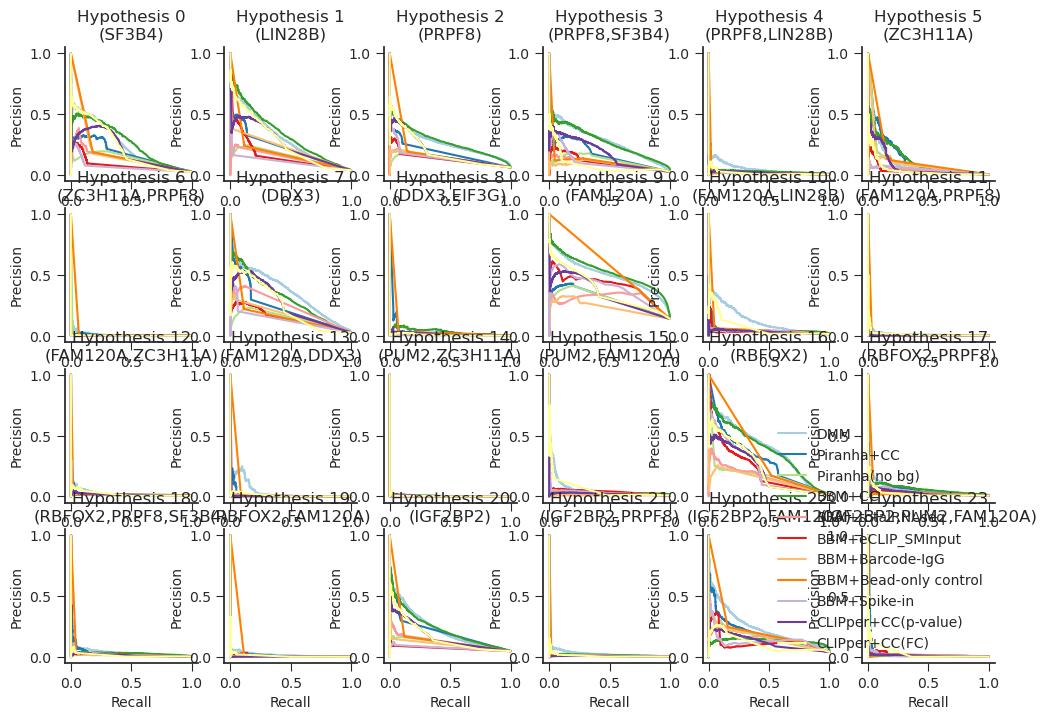

In [35]:
sns.set_palette('Paired')
auprc_df = collapsed_auprc(all_score_by_hypothesis, collapsed_cluster, collapsed_cluster_anno)
plt.savefig(figdir/'Hypothesis_AUPRC.pdf')


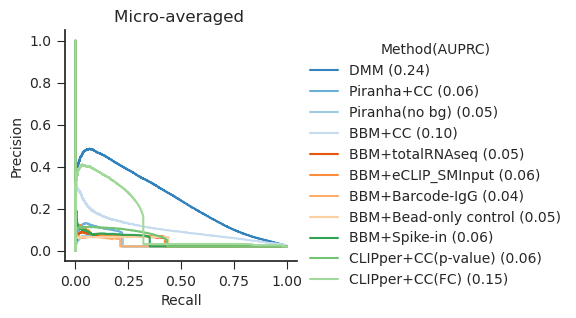

In [36]:
# microaverage precision recall
sns.set_palette('tab20c')

# For each class
Y_test = all_score_by_hypothesis['eCLIP']
precision = dict()
recall = dict()
average_precision = dict()
f, ax = plt.subplots(figsize = (3,3))

for name in all_score_by_hypothesis.keys():
    # A "micro-average": quantifying score on all classes jointly
    
    if name != 'eCLIP':
    
        y_score = all_score_by_hypothesis[name]
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            Y_test.values.ravel(), y_score.values.ravel()
        )
        average_precision["micro"] = average_precision_score(
            Y_test, 
            y_score, average="micro")
        display = PrecisionRecallDisplay(
            recall=recall["micro"],
            precision=precision["micro"],
            average_precision=average_precision["micro"],
        )
        auprc = auc(recall["micro"], precision["micro"])
        display.plot(label = f'{name} ({auprc:.2f})', ax = ax)
        _ = display.ax_.set_title("Micro-averaged ")
ax.legend(bbox_to_anchor = (1, 1), title = 'Method(AUPRC)')
sns.despine()
plt.savefig(figdir/'Hypothesis_micro_AUPRC.pdf')

In [37]:
def pairwise_compare_AUPRC(auprc_df, col1, col2):
    auprc_df.plot.scatter(x = col1, y = col2,figsize = (3,3), color = 'grey')
    plt.plot([0,auprc_df['DMM'].max()],[0,auprc_df['DMM'].max()], '--', color = 'grey')
    for index, row in auprc_df.loc[(auprc_df[col1]-auprc_df[col2]).abs()>0.03].iterrows():
        plt.annotate(index,(row[col1], row[col2]),xytext=(row[col1]-0.06, row[col2]+0.03),
                    arrowprops=dict(arrowstyle= '-',))
    sns.despine()
    plt.xlabel(f'AUPRC({col1})')
    plt.ylabel(f'AUPRC({col2})')
    plt.savefig(figdir/f'AUPRC_scatter.{col1}vs{col2}.pdf')

In [38]:
auprc_df_pivot = pd.pivot_table(auprc_df, index = 'RBP', columns = 'name', values = 'AUPRC')

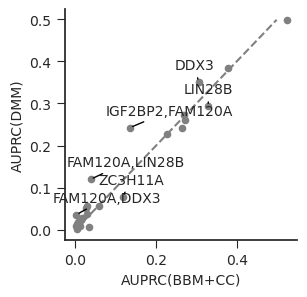

In [39]:
pairwise_compare_AUPRC(auprc_df_pivot, 'BBM+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_BBM+CC.pdf')

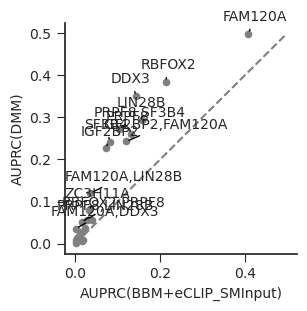

In [40]:
pairwise_compare_AUPRC(auprc_df_pivot, 'BBM+eCLIP_SMInput', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_BBM+smi.pdf')

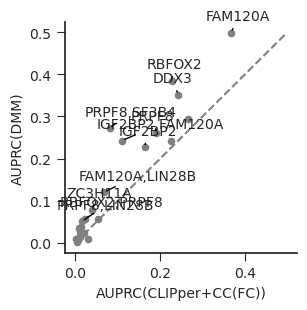

In [41]:
pairwise_compare_AUPRC(auprc_df_pivot, 'CLIPper+CC(FC)', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_CLIPper.pdf')

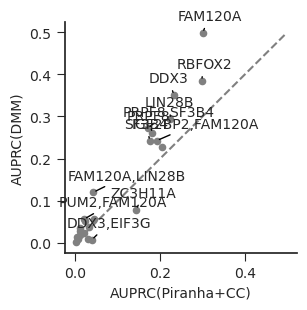

In [42]:
pairwise_compare_AUPRC(auprc_df_pivot, 'Piranha+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_combinatorial_Piranha.pdf')

In [43]:
auprc_df.groupby(by = 'name').median()

/tmp/ipykernel_2258679/4114013513.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  auprc_df.groupby(by = 'name').median()


,Hypothesis No.,AUPRC
name,,
BBM+Barcode-IgG,11.5,0.012961
BBM+Bead-only control,11.5,0.056103
BBM+CC,11.5,0.035608
BBM+Spike-in,11.5,0.032838
BBM+eCLIP_SMInput,11.5,0.029621
BBM+totalRNAseq,11.5,0.019023
CLIPper+CC(FC),11.5,0.034479
CLIPper+CC(p-value),11.5,0.024302
DMM,11.5,0.056431


In [44]:
import matplotlib.patches as mpatches
order = ['DMM', 'BBM+CC', 'CLIPper+CC(p-value)', 'CLIPper+CC(FC)', 'Piranha+CC', 'Piranha(no bg)', 
         'BBM+Barcode-IgG', 'BBM+Bead-only control', 'BBM+Spike-in',
       'BBM+eCLIP_SMInput', 'BBM+totalRNAseq']
color_order = ['magenta']*2+['grey']*2 +['lightgrey']*2+['rosybrown']*5
color_dict = dict(zip(order, color_order))
lgd = [mpatches.Patch(color=c, label=o) for o,c in zip(order, color_order)]
color_unique = ['magenta','grey','lightgrey','rosybrown']
types = ['Mudskipper', 'CLIPper', 'Piranha', 'Mudskipper+external background']
lgd_uniq = [mpatches.Patch(color=c, label=o) for o,c in zip(types, color_unique)]

In [45]:
color_dict

{'DMM': 'magenta',
 'BBM+CC': 'magenta',
 'CLIPper+CC(p-value)': 'grey',
 'CLIPper+CC(FC)': 'grey',
 'Piranha+CC': 'lightgrey',
 'Piranha(no bg)': 'lightgrey',
 'BBM+Barcode-IgG': 'rosybrown',
 'BBM+Bead-only control': 'rosybrown',
 'BBM+Spike-in': 'rosybrown',
 'BBM+eCLIP_SMInput': 'rosybrown',
 'BBM+totalRNAseq': 'rosybrown'}

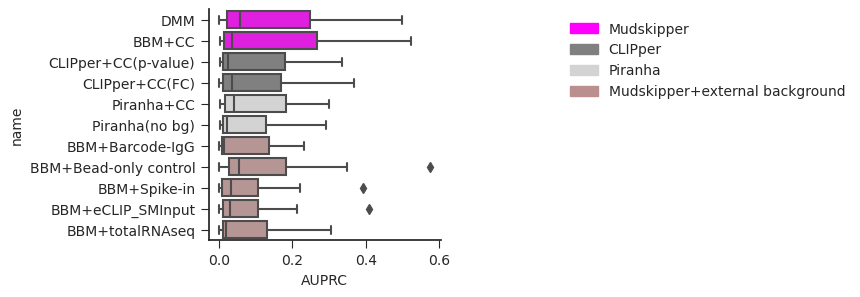

In [46]:
f, ax = plt.subplots(figsize = (3,3))

sns.boxplot(auprc_df, y = 'name', x = 'AUPRC',  ax = ax, order = order, palette = color_dict)
sns.despine()
plt.legend(handles = lgd_uniq, bbox_to_anchor = (1.5,1))
plt.savefig(figdir/f'AUPRC_boxplot.pdf')

## Binary classification: Whether is a binding site for 1 RBP

In [47]:
def accuracy_among_topk(score, truth, k):
    indicies = score.sort_values(ascending = False).iloc[:k].index
    return truth.loc[indicies].mean()


In [48]:
def by_rbp_topk(all_scores, goldstandard_key = 'eCLIP', subset_cols = None, figsize = (12,4)):
    ground_truth = all_scores[goldstandard_key]
    # plot ROC curve
    if subset_cols:
        to_plot = subset_cols
    else:
        to_plot = ground_truth.columns
    f, axes = plt.subplots(2 if len(to_plot)>1 else 1,
                           math.ceil(len(to_plot)/2), 
                           figsize = figsize, 
                           sharex = True, sharey = False)
    try:
        axes = axes.flatten()
    except Exception as e:
        print(e)
        axes=[axes]
    topk_data = []
    for col in to_plot:
        truth = ground_truth[col]
        
        
        # DMM
        for name in all_scores.keys():
            if name != goldstandard_key:
                score = all_scores[name][col]
                for k in [500, 1000, 5000]:
                    topk_acc = accuracy_among_topk(score, truth, k)
                
                    topk_data.append([col, topk_acc, name, k])

    topk_data = pd.DataFrame(topk_data, 
                        columns=['RBP', 'Accuracy', 'name', 'k'])
    
    for i, (ax, (name, group)) in enumerate(zip(axes.flatten(), topk_data.groupby(by = 'RBP'))):
        if i == len(to_plot)-1:
            legend = True
        else:
            legend = False
        pd.pivot_table(group, index = 'k', columns = 'name', values = 'Accuracy'
                      ).plot.bar(ax = ax,
                                legend = legend)

        ax.set_title(name)

        if legend:
            ax.legend(bbox_to_anchor = (1.5, 1))
        
    sns.despine()
    return topk_data

In [49]:
all_scores.keys()

dict_keys(['DMM', 'Piranha+CC', 'Piranha(no bg)', 'BBM+CC', 'BBM+totalRNAseq', 'BBM+eCLIP_SMInput', 'BBM+Barcode-IgG', 'BBM+Bead-only control', 'BBM+Spike-in', 'CLIPper+CC(p-value)', 'CLIPper+CC(FC)', 'eCLIP'])

In [50]:
all_score_by_hypothesis.keys()

dict_keys(['eCLIP', 'DMM', 'Piranha+CC', 'Piranha(no bg)', 'BBM+CC', 'BBM+totalRNAseq', 'BBM+eCLIP_SMInput', 'BBM+Barcode-IgG', 'BBM+Bead-only control', 'BBM+Spike-in', 'CLIPper+CC(p-value)', 'CLIPper+CC(FC)'])

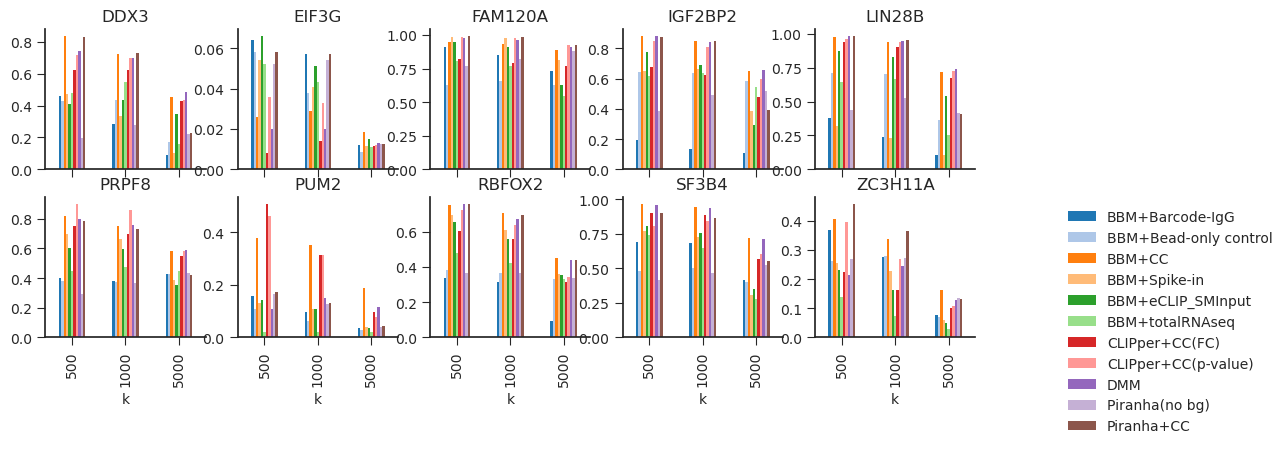

In [51]:
sns.set_palette('tab20')
topk_df = by_rbp_topk(all_scores)

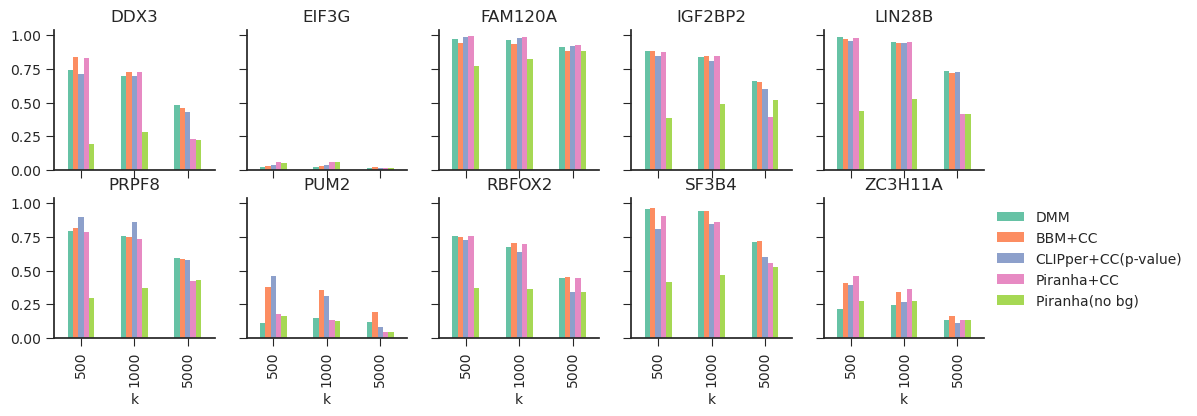

In [52]:
# simplify
sns.set_palette('Set2')
figsize = (12,4)
sub_topk_data = topk_df.loc[(topk_df['name']=='DMM')|(topk_df['name']=='BBM+CC')|
(topk_df['name']=='Piranha+CC') | (topk_df['name']=='CLIPper+CC(p-value)')|
(topk_df['name']=='Piranha(no bg)')]
to_plot = ground_truth.columns
f, axes = plt.subplots(2 if len(to_plot)>1 else 1,
                           math.ceil(len(to_plot)/2), 
                           figsize = figsize, 
                           sharex = True, sharey = True)
for i, (ax, (name, group)) in enumerate(zip(axes.flatten(), sub_topk_data.groupby(by = 'RBP'))):
    if i == len(to_plot)-1:
        legend = True
    else:
        legend = False
    pd.pivot_table(group, index = 'k', columns = 'name', values = 'Accuracy'
                  ).T.loc[['DMM', 'BBM+CC', 'CLIPper+CC(p-value)',
                           'Piranha+CC', 'Piranha(no bg)']].T.plot.bar(ax = ax,
                            legend = legend)

    ax.set_title(name)

    if legend:
        ax.legend(bbox_to_anchor = (1, 1))
sns.despine()
plt.savefig(figdir/'topkdir_subset.pdf')


In [102]:
pvpv = pd.pivot_table(sub_topk_data.loc[sub_topk_data['k']==500],
               index = 'RBP', columns = 'name', values = 'Accuracy')
pvpv['DMM'].ge(pvpv['CLIPper+CC(p-value)'])

RBP
DDX3        True
EIF3G      False
FAM120A    False
IGF2BP2     True
LIN28B      True
PRPF8      False
PUM2       False
RBFOX2      True
SF3B4       True
ZC3H11A    False
dtype: bool

In [ ]:
pvpv['DMM'].ge(pvpv['CLIPper+CC(p-value)'])

In [103]:
pvpv['BBM+CC'].ge(pvpv['CLIPper+CC(p-value)'])

RBP
DDX3        True
EIF3G      False
FAM120A    False
IGF2BP2     True
LIN28B      True
PRPF8      False
PUM2       False
RBFOX2      True
SF3B4       True
ZC3H11A     True
dtype: bool

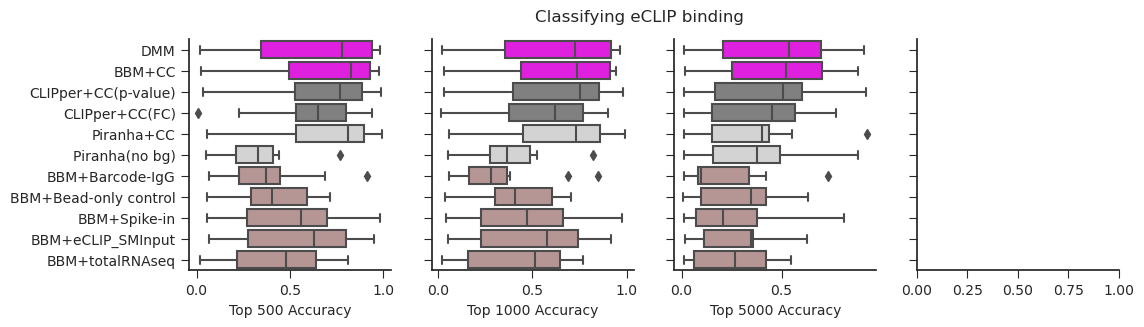

In [54]:
f, axes = plt.subplots(1,4, figsize = (12,3), sharey = True)
for ax, (name, group) in zip(axes, topk_df.groupby(by = 'k')):
    sns.boxplot(group, y = 'name', x = 'Accuracy', ax = ax, 
               palette = color_dict, order = order)
    ax.set_xlabel(f'Top {name} Accuracy')
    ax.set_ylabel(f'')
sns.despine()
plt.suptitle('Classifying eCLIP binding')
plt.savefig(figdir / 'topk_boxplot.pdf')

In [55]:
pd.pivot_table(topk_df, index = ['RBP', 'name'], columns = 'k', values = 'Accuracy').to_csv(figdir/'Topk.csv')

In [56]:
def by_rbp_auprc(all_scores, goldstandard_key = 'eCLIP', subset_cols = None, figsize = (12,4)):
    ground_truth = all_scores[goldstandard_key]
    # plot ROC curve
    if subset_cols:
        to_plot = subset_cols
    else:
        to_plot = ground_truth.columns
    f, axes = plt.subplots(2 if len(to_plot)>1 else 1,
                           math.ceil(len(to_plot)/2), 
                           figsize = figsize, 
                           sharex = True, sharey = True)
    try:
        axes = axes.flatten()
    except Exception as e:
        print(e)
        axes=[axes]
    auprc_data = []
    for col, ax in zip(to_plot, axes):
        truth = ground_truth[col]
        
        ax.set_title(col)
        ax.set_ylabel('Recall')
        ax.set_xlabel('Precision')
        
        # DMM
        for name in all_scores.keys():
            if name != goldstandard_key:
                score = all_scores[name][col]
                precision, recall, thresholds = precision_recall_curve(truth, 
                                                                    score)
                auprc = auc(recall, precision)
                ax.plot(recall, precision, label = f'{name}({auprc:.2f})')
                auprc_data.append([col, auprc, name])

    ax.legend(bbox_to_anchor = (1,1.5))
    sns.despine()
    plt.tight_layout()
    
    
    return pd.DataFrame(auprc_data, 
                        columns=['RBP', 'AUPRC', 'name'])

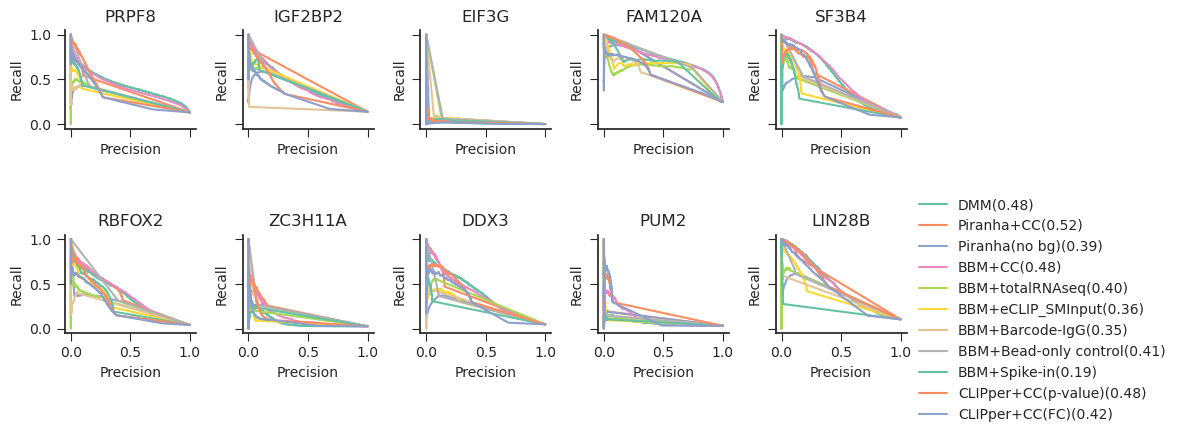

In [57]:
auprc_df_byrbp = by_rbp_auprc(all_scores)

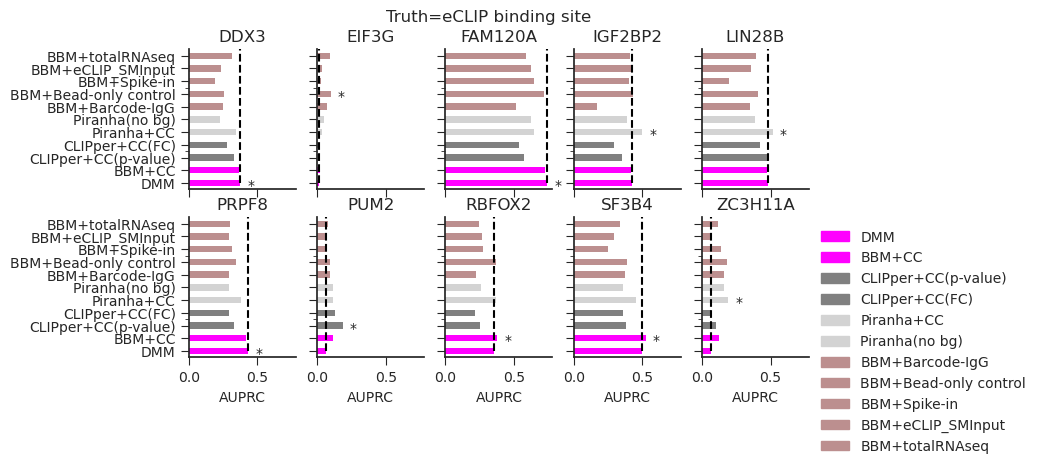

In [58]:
pv_auprc = pd.pivot_table(auprc_df_byrbp, index = 'name', columns = 'RBP', values = 'AUPRC')



f, axes = plt.subplots(2,5,figsize = (8,4), sharex = True, sharey = True)
for col, ax in zip(pv_auprc.columns, axes.flatten()):
    val = pv_auprc[col]
    val[order].plot.barh(
        xlabel = 'AUPRC', 
        ax = ax, 
        color = color_order
    )
    ax.vlines(x = val['DMM'], ymin = 0, ymax = len(val), linestyle = 'dashed', color = 'black')
    ax.set_title(col)
    ax.set_ylabel('')
    best = val.idxmax()
    ax.text(x = val[best]+0.05, y = order.index(best)-0.5, s = '*')
sns.despine()
plt.legend(handles=lgd, bbox_to_anchor = (1,1))
plt.suptitle('Truth=eCLIP binding site')
plt.savefig(figdir/f'AUPRC_individual_bar.pdf')

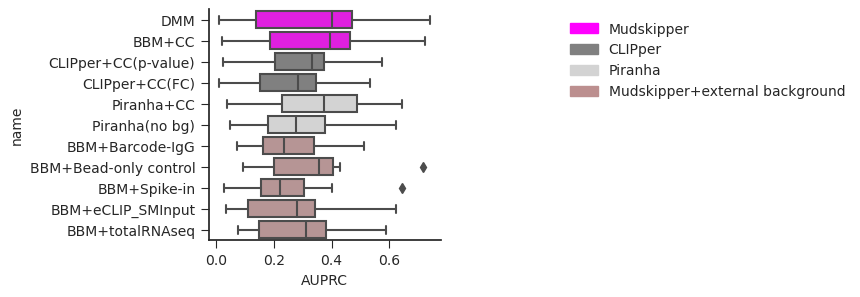

In [59]:
f, ax = plt.subplots(figsize = (3,3))

sns.boxplot(auprc_df_byrbp, y = 'name', x = 'AUPRC',  ax = ax, order = order, palette = color_dict)
sns.despine()
plt.legend(handles = lgd_uniq, bbox_to_anchor = (1.5,1))
plt.savefig(figdir/f'AUPRC_individual_boxplot.pdf')

In [60]:
auprc_df_byrbp_pivot = pd.pivot_table(auprc_df_byrbp, index = 'RBP', columns = 'name', values = 'AUPRC')

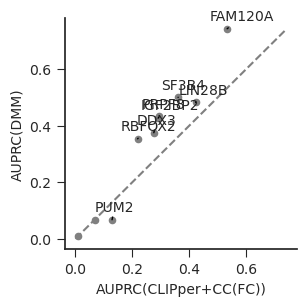

In [61]:
pairwise_compare_AUPRC(auprc_df_byrbp_pivot, 'CLIPper+CC(FC)', 'DMM')
plt.savefig(figdir/f'AUPRC_individual_DMMvsCLIPper.pdf')

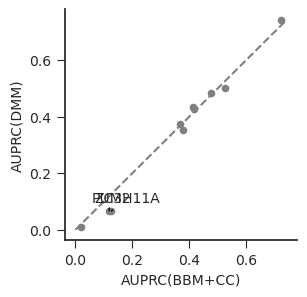

In [62]:
pairwise_compare_AUPRC(auprc_df_byrbp_pivot, 'BBM+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_individual_DMMvsBBMCCr.pdf')

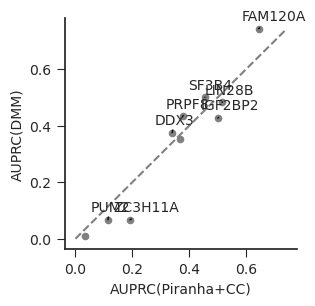

In [63]:
pairwise_compare_AUPRC(auprc_df_byrbp_pivot, 'Piranha+CC', 'DMM')
plt.savefig(figdir/f'AUPRC_individual_DMMvsPiranha.pdf')

# Motifs

In [64]:

window_bed = BedTool('/tscc/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_df = pd.read_csv(window_bed.fn, sep = '\t')

pum_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_pum2.homer.motif', sep = '\t')
pum_motif = pum_motif.loc[pum_motif['Motif Name']=='1-TGTATATA']
pum_motif['windowstrand']=pum_motif['PositionID'].map(window_df.set_index('name')['strand'])
pum_motif.dropna(inplace = True)
pum_motif = pum_motif.loc[pum_motif['Strand']==pum_motif['windowstrand']]

rbfox2_motif = pd.read_csv('/tscc/nfs/home/hsher/scratch/k562_window_rbfox2.homer.motif', sep = '\t')
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Motif Name'].isin(
    ['1-TGCATG', '2-GCATST', '3-AGCATG','8-TGCACA', '9-TGCACG']                                                            
)
]
rbfox2_motif['windowstrand']=rbfox2_motif['PositionID'].map(window_df.set_index('name')['strand'])
rbfox2_motif.dropna(inplace = True)
rbfox2_motif = rbfox2_motif.loc[rbfox2_motif['Strand']==rbfox2_motif['windowstrand']]


In [65]:
def read_everything(rbp):
    beta = pd.read_csv(basedir / 'beta-mixture_CC'/f'{out_stem}.{rbp}.enriched_windows.tsv', sep = '\t')
    prianha =pd.read_csv(basedir/ 'comparison' / 'piranha' / 'CC'/f'{out_stem}.{rbp}.bed',
                         names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'],
                         sep = '\t')
    skipper = pd.read_csv(basedir / 'skipper_CC'/'enriched_windows'/f'{out_stem}.{rbp}.enriched_windows.tsv.gz',
                          sep = '\t')
    return beta, prianha, skipper
    

In [66]:
rbp = 'PUM2'
b,p,s = read_everything(rbp)

motif_df = pum_motif
b['is_motif']=b['name'].isin(motif_df['PositionID'])
p['is_motif']=p['name'].isin(motif_df['PositionID'])
s['is_motif']=s['name'].isin(motif_df['PositionID'])
dmm = megaoutput.loc[megaoutput[f'{out_stem}.{rbp}']].copy()
dmm['is_motif'] = dmm['name'].isin(motif_df['PositionID'])
clipper = ground_truth.loc[ground_truth[rbp]].copy()
clipper['is_motif'] = clipper.index.isin(motif_df['PositionID'])
eclip = ground_truth_skipper.loc[ground_truth_skipper[rbp]].copy()
eclip['is_motif'] = eclip.index.isin(motif_df['PositionID'])

motif_cnt = pd.concat([dmm.groupby(by = 'is_motif').count()['name'],
    b.groupby(by = 'is_motif').count()['name'],
             p.groupby(by = 'is_motif').count()['name'],
             s.groupby(by = 'is_motif').count()['name'],
             
             clipper.groupby(by = 'is_motif').count().iloc[:,0],
             eclip.groupby(by = 'is_motif').count().iloc[:,0]
            ], axis = 1)
motif_cnt.columns = ['DMM','Beta', 'Piranha', 'Skipper', 'CLIPper', 'eCLIP']

In [67]:
rbp = 'RBFOX2'
b,p,s = read_everything(rbp)
motif_df = rbfox2_motif
b['is_motif']=b['name'].isin(motif_df['PositionID'])
p['is_motif']=p['name'].isin(motif_df['PositionID'])
s['is_motif']=s['name'].isin(motif_df['PositionID'])
dmm = megaoutput.loc[megaoutput[f'{out_stem}.{rbp}']].copy()
dmm['is_motif'] = dmm['name'].isin(motif_df['PositionID'])
clipper = ground_truth.loc[ground_truth[rbp]].copy()
clipper['is_motif'] = clipper.index.isin(motif_df['PositionID'])
eclip = ground_truth_skipper.loc[ground_truth_skipper[rbp]].copy()
eclip['is_motif'] = eclip.index.isin(motif_df['PositionID'])

motif_cnt_fox2 = pd.concat([
    dmm.groupby(by = 'is_motif').count()['name'],
    b.groupby(by = 'is_motif').count()['name'],
             p.groupby(by = 'is_motif').count()['name'],
             s.groupby(by = 'is_motif').count()['name'],
             
             clipper.groupby(by = 'is_motif').count().iloc[:,0],
             eclip.groupby(by = 'is_motif').count().iloc[:,0]
            ], axis = 1)
motif_cnt_fox2.columns = ['DMM','Beta', 'Piranha', 'Skipper', 'CLIPper', 'eCLIP']


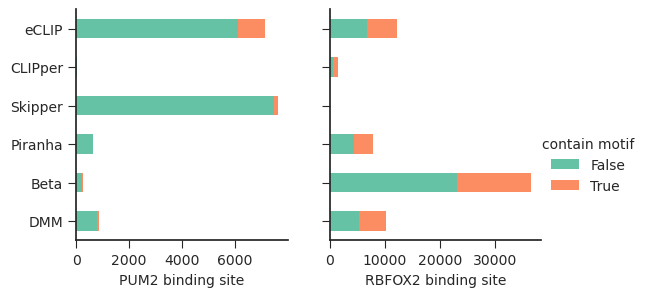

In [68]:
sns.set_palette('Set2')
f, ax = plt.subplots(1,2, sharey = True, figsize = (6,3))
motif_cnt.T.plot.barh(stacked = True, ax = ax[0], legend = False)
motif_cnt_fox2.T.plot.barh(stacked = True, ax = ax[1])
ax[0].set_xlabel('PUM2 binding site')
ax[1].set_xlabel('RBFOX2 binding site')
ax[1].legend(bbox_to_anchor = (1.5, 0.5), title = 'contain motif')
sns.despine()
plt.savefig(figdir/f'PUM2_RBFOX2_nmotif.pdf')

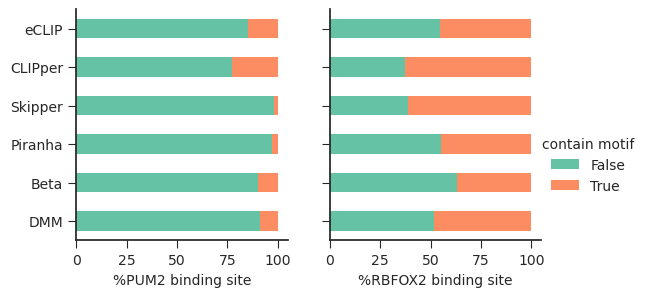

In [69]:
f, ax = plt.subplots(1,2, sharey = True, figsize = (6,3))
(100*(motif_cnt.div(motif_cnt.sum(axis = 0), axis = 1))).T.plot.barh(stacked = True, ax = ax[0], legend = False)
(100*(motif_cnt_fox2.div(motif_cnt_fox2.sum(axis = 0), axis = 1))).T.plot.barh(stacked = True, ax = ax[1])
ax[0].set_xlabel('%PUM2 binding site')
ax[1].set_xlabel('%RBFOX2 binding site')
ax[1].legend(bbox_to_anchor = (1.5, 0.5), title = 'contain motif')
sns.despine()
plt.savefig(figdir/f'PUM2_RBFOX2_precmotif.pdf')

In [70]:
motif_cnt.div(motif_cnt.sum(axis = 0), axis = 1)

,DMM,Beta,Piranha,Skipper,CLIPper,eCLIP
is_motif,,,,,,
False,0.913507,0.901575,0.972136,0.983833,0.774194,0.854624
True,0.086493,0.098425,0.027864,0.016167,0.225806,0.145376


In [71]:
motif_cnt_fox2.div(motif_cnt_fox2.sum(axis = 0), axis = 1)

,DMM,Beta,Piranha,Skipper,CLIPper,eCLIP
is_motif,,,,,,
False,0.515312,0.633354,0.550006,0.385417,0.374658,0.54506
True,0.484688,0.366646,0.449994,0.614583,0.625342,0.45494


In [72]:
sub = ['DMM', 'BBM+CC', 'CLIPper+CC(p-value)', 'Piranha+CC', 'Piranha(no bg)']
sub_color = ['magenta', 'pink', 'grey', 'lightgrey', 'k']
sub_color_dict = dict(zip(sub, sub_color))

def by_rbp_topk_motif(all_scores, ground_truth, subset_cols = None, figsize = (12,4), groups_to_evaluate = None):
    
    # plot ROC curve
    if subset_cols:
        to_plot = subset_cols
    else:
        to_plot = ground_truth.columns

    if groups_to_evaluate:
        group_to_plot = groups_to_evaluate
    else:
        group_to_evaluate = all_scores.keys()
    f, axes = plt.subplots(2 if len(to_plot)>1 else 1,
                           math.ceil(len(to_plot)/2), 
                           figsize = figsize, 
                           sharex = True, sharey = False)
    try:
        axes = axes.flatten()
    except Exception as e:
        print(e)
        axes=[axes]
    topk_data = []
    for col in to_plot:
        
        
        
        # DMM
        for name in group_to_plot:
            
            score = all_scores[name][col]
            for k in [500, 1000, 5000]:
                topk_acc = accuracy_among_topk(score, ground_truth, k)
            
                topk_data.append([col, topk_acc, name, k])

    topk_data = pd.DataFrame(topk_data, 
                        columns=['RBP', 'Accuracy', 'name', 'k'])
    
    for i, (ax, (name, group)) in enumerate(zip(axes, topk_data.groupby(by = 'RBP'))):
        if i == len(to_plot)-1:
            legend = True
        else:
            legend = False
        
        pv = pd.pivot_table(group, index = 'k', columns = 'name', values = 'Accuracy'
                      )
        pv[group_to_plot].plot.barh(ax = ax,legend = legend, color = sub_color_dict)
        print(pv)

        ax.set_title(name)

        if legend:
            ax.legend(bbox_to_anchor = (1.5, 1))
        
    sns.despine()
    return topk_data

In [73]:
# label
by_rbp = all_scores['DMM']
pum_motif_binary = pd.Series(by_rbp.index.isin(pum_motif['PositionID']), index = by_rbp.index)
rbfox2_motif_binary = pd.Series(by_rbp.index.isin(rbfox2_motif['PositionID']), index = by_rbp.index)

In [74]:
pum_motif_binary.sum(), rbfox2_motif_binary.sum()

(1357, 41867)

In [75]:
color_dict

{'DMM': 'magenta',
 'BBM+CC': 'magenta',
 'CLIPper+CC(p-value)': 'grey',
 'CLIPper+CC(FC)': 'grey',
 'Piranha+CC': 'lightgrey',
 'Piranha(no bg)': 'lightgrey',
 'BBM+Barcode-IgG': 'rosybrown',
 'BBM+Bead-only control': 'rosybrown',
 'BBM+Spike-in': 'rosybrown',
 'BBM+eCLIP_SMInput': 'rosybrown',
 'BBM+totalRNAseq': 'rosybrown'}

'Axes' object has no attribute 'flatten'
name  BBM+CC  CLIPper+CC(p-value)     DMM  Piranha(no bg)  Piranha+CC
k                                                                    
500   0.0860               0.1040  0.0080          0.0220      0.0220
1000  0.0720               0.0640  0.0160          0.0180      0.0210
5000  0.0382               0.0168  0.0194          0.0088      0.0088
'Axes' object has no attribute 'flatten'
name  BBM+CC  CLIPper+CC(p-value)     DMM  Piranha(no bg)  Piranha+CC
k                                                                    
500   0.6660               0.5520  0.6540          0.4380      0.6420
1000  0.6520               0.5780  0.6590          0.4320      0.6070
5000  0.5684               0.5298  0.5708          0.4438      0.5208


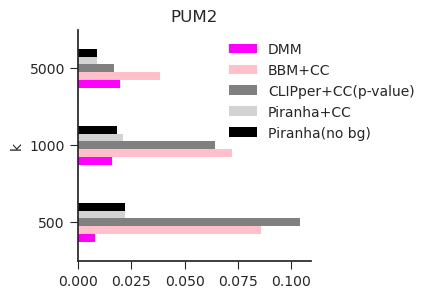

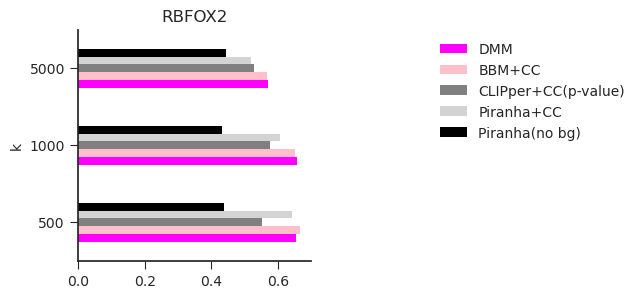

In [76]:
#f, ax = plt.subplots(1,2)
topk_pum2_motif_data = by_rbp_topk_motif(
    all_scores, pum_motif_binary, subset_cols = ['PUM2'], figsize = (3,3),
    groups_to_evaluate = ['DMM', 'BBM+CC', 'CLIPper+CC(p-value)', 'Piranha+CC', 'Piranha(no bg)'],
    
                        )
plt.savefig(figdir / 'topk_PUM2_motif.pdf')
topk_pum2_motif_data = by_rbp_topk_motif(
    all_scores, rbfox2_motif_binary, subset_cols = ['RBFOX2'], figsize = (3,3),
    groups_to_evaluate = ['DMM', 'BBM+CC', 'CLIPper+CC(p-value)', 'Piranha+CC', 'Piranha(no bg)'],
    )
plt.savefig(figdir / 'topk_RBFOX2_motif.pdf')


'Axes' object has no attribute 'flatten'
name  BBM+CC  CLIPper+CC(p-value)     DMM  Piranha(no bg)  Piranha+CC
k                                                                    
500   0.6660               0.5520  0.6540          0.4380      0.6420
1000  0.6520               0.5780  0.6590          0.4320      0.6070
5000  0.5684               0.5298  0.5708          0.4438      0.5208


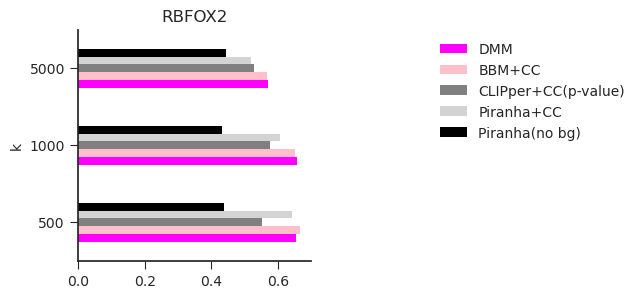

In [77]:
topk_pum2_motif_data = by_rbp_topk_motif(all_scores, rbfox2_motif_binary, subset_cols = ['RBFOX2'], figsize = (3,3),
                                        groups_to_evaluate = ['DMM', 'BBM+CC', 'CLIPper+CC(p-value)', 'Piranha+CC', 'Piranha(no bg)'])
plt.savefig(figdir / 'topk_RBFOX2_motif.pdf')

In [78]:
def by_rbp_auprc_motif(all_scores, ground_truth, subset_cols = None, figsize = (12,4)):
    
    # plot ROC curve
    if subset_cols:
        to_plot = subset_cols
    else:
        to_plot = ground_truth.columns
    f, axes = plt.subplots(2 if len(to_plot)>1 else 1,
                           math.ceil(len(to_plot)/2), 
                           figsize = figsize, 
                           sharex = True, sharey = True)
    try:
        axes = axes.flatten()
    except Exception as e:
        print(e)
        axes=[axes]
    auprc_data = []
    for col, ax in zip(to_plot, axes):
        
        
        ax.set_title(col)
        ax.set_ylabel('Recall')
        ax.set_xlabel('Precision')
        
        # DMM
        for name in all_scores.keys():
            score = all_scores[name][col]
            precision, recall, thresholds = precision_recall_curve(ground_truth, 
                                                                score)
            auprc = auc(recall, precision)
            ax.plot(recall, precision, label = f'{name}({auprc:.2f})')
            auprc_data.append([col, auprc, name])

    ax.legend(bbox_to_anchor = (1,1.5))
    sns.despine()
    plt.tight_layout()
    
    
    return pd.DataFrame(auprc_data, 
                        columns=['RBP', 'AUPRC', 'name'])

'Axes' object has no attribute 'flatten'


/tmp/ipykernel_2258679/177808943.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


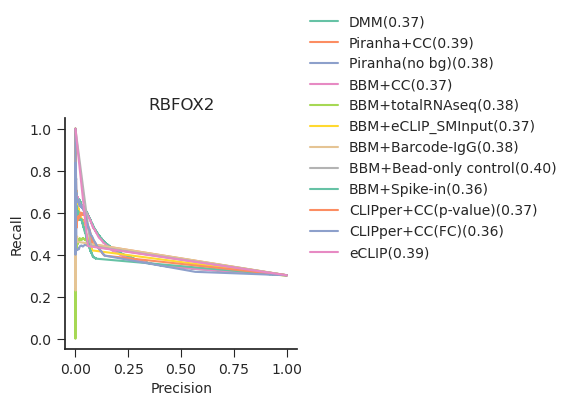

In [79]:
auprc_rbfox2_motif_data = by_rbp_auprc_motif(all_scores, rbfox2_motif_binary, subset_cols = ['RBFOX2'], figsize = (3,3),
                                       )
plt.show()


'Axes' object has no attribute 'flatten'


/tmp/ipykernel_2258679/177808943.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


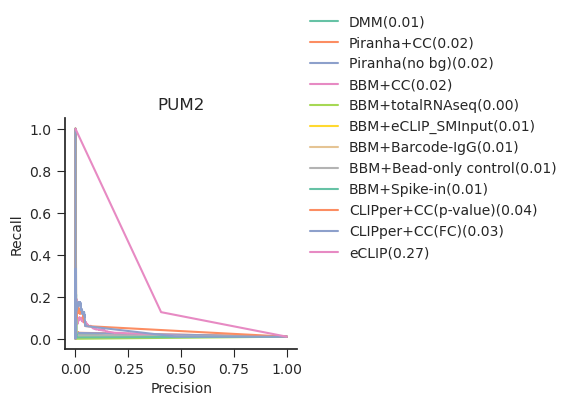

In [80]:
auprc_pum2_motif_data = by_rbp_auprc_motif(all_scores, pum_motif_binary, subset_cols = ['PUM2'], figsize = (3,3),
                                       )


In [81]:
auprc_rbfox2_motif_data['name']

0                       DMM
1                Piranha+CC
2            Piranha(no bg)
3                    BBM+CC
4           BBM+totalRNAseq
5         BBM+eCLIP_SMInput
6           BBM+Barcode-IgG
7     BBM+Bead-only control
8              BBM+Spike-in
9       CLIPper+CC(p-value)
10           CLIPper+CC(FC)
11                    eCLIP
Name: name, dtype: object

In [82]:
len(color_order), len(order)

(11, 11)

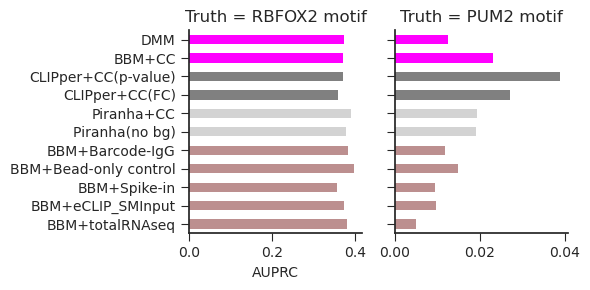

In [83]:

f, ax = plt.subplots(1,2, figsize = (6,3), sharey = True)
auprc_rbfox2_motif_data.set_index('name').loc[order][::-1]['AUPRC'].plot.barh(
    color = color_order[::-1], ax = ax[0])
ax[0].set_title('Truth = RBFOX2 motif')
auprc_pum2_motif_data.set_index('name').loc[order][::-1]['AUPRC'].plot.barh(
    color = color_order[::-1],  ax = ax[1])
ax[1].set_title('Truth = PUM2 motif')
ax[0].set_xlabel('AUPRC')
_ = [a.set_ylabel('') for a in ax]
sns.despine()
plt.tight_layout()
plt.savefig(figdir / 'AUPRC_motif.pdf')

# Shared binding site

In [84]:
def mask_output(identity_tbl):
    ''' apply softmask to non-DMM outputs for fair comparison '''
    # mask
    common_index = list(set(identity_tbl.index).intersection(set(mask.index)))
    
    identity_tbl.loc[common_index, mask.columns] = identity_tbl.loc[common_index, mask.columns] & mask # being logLR > 2 and >2*stdev
    return identity_tbl

In [85]:
def get_beta_mixture_identity_tbl(root_dir):
    identity_tbl = []
    for fname in list(root_dir.glob(f'{out_stem}*window_score.tsv')):
        libname, rbp = fname.name.split('.')[:2]
        df = pd.read_csv(fname, index_col = 0, sep = '\t')
        value = df.set_index('name')['enriched']
        value.name = rbp
        identity_tbl.append(value)
        
    identity_tbl = pd.concat(identity_tbl, axis = 1).fillna(False)
    
    
    return mask_output(identity_tbl)

In [86]:
all_identity_matrix = {}
all_identity_matrix['eCLIP']=ground_truth_skipper
all_identity_matrix['DMM']=megaoutput[anno.columns]

all_identity_matrix['CLIPper+CC']=clipper_1rep
all_identity_matrix['Piranha+CC']=mask_output(all_scores['Piranha+CC'].ge(0.95))

for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_identity_matrix[f'BBM+{ext_background}'] = mask_output(get_beta_mixture_identity_tbl(
        basedir / f'beta-mixture_external/{ext_background}'))

In [87]:
# calculate jaccard index
def compute_jaccard_index(identity_tbl):
    ''' use jaccard index to show how much binding site overlapped between RBPs'''
    d_condense = pdist(identity_tbl.T, 'jaccard')
    d = pd.DataFrame(1-squareform(d_condense), index = identity_tbl.columns, columns = identity_tbl.columns)
    return d


list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


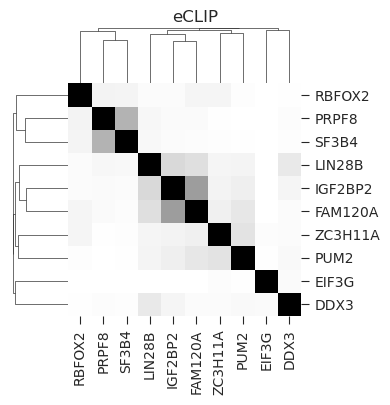

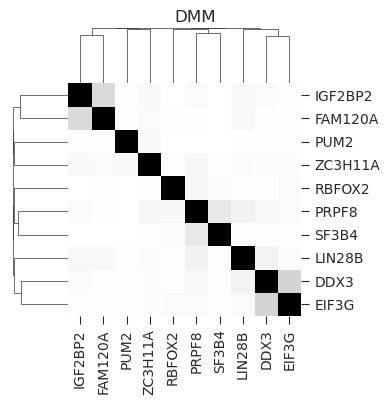

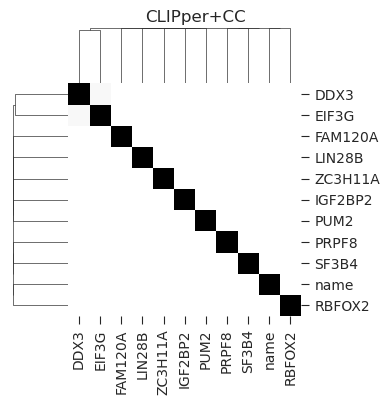

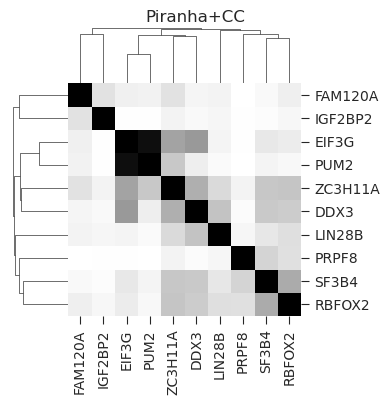

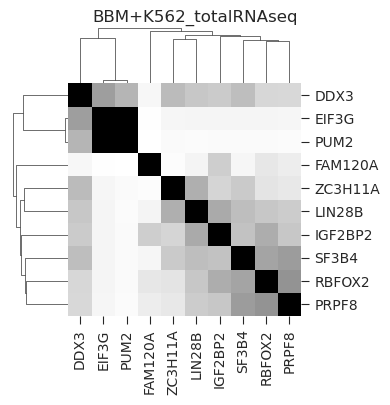

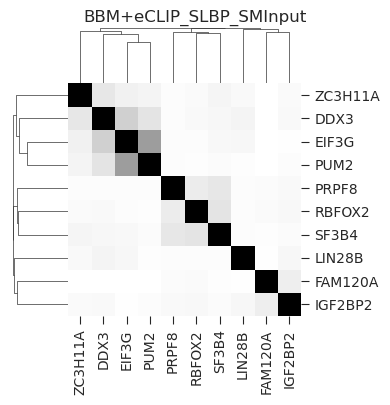

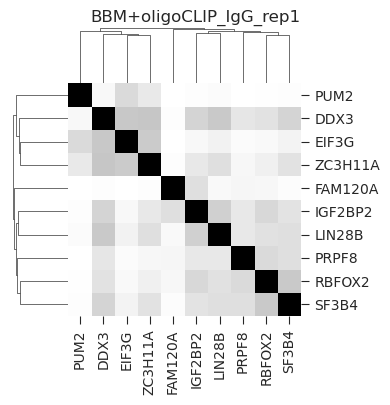

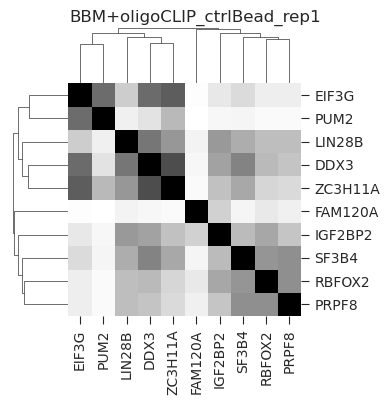

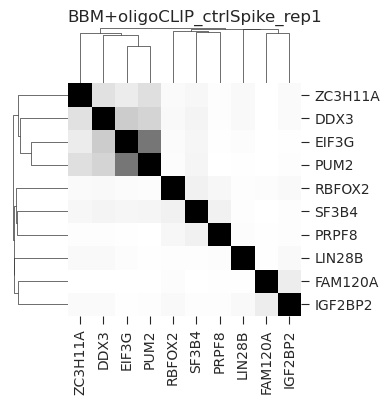

In [88]:
for key in all_identity_matrix:
    d_dmm = compute_jaccard_index(all_identity_matrix[key])
    try:
        d_dmm.index = [i.split('.')[1] for i in d_dmm.index]
        d_dmm.columns = [i.split('.')[1] for i in d_dmm.columns]
    except Exception as e:
        print(e)
    cm=sns.clustermap(d_dmm, cmap = 'Greys', metric = 'correlation', figsize = (4,4),
                vmax = 0.3)
    cm.cax.set_visible(False)
    plt.suptitle(f'{key}', y = 1)
    plt.savefig(figdir/f'jaccard_{key}.pdf')

In [89]:

def plot_pairs(all_identity_matrix, pairs, ax=None, legend = False):
    all_counts = []
    for key in all_identity_matrix.keys():
        df = all_identity_matrix[key]
        try:
            subset = df.loc[df[pairs].all(axis = 1)]
        except Exception as e:
            print(e)
            subset = df.loc[df[[f'{out_stem}.{rbp}' for rbp in pairs]].all(axis = 1)]
                    
        cnt = window_df.loc[window_df['name'].isin(subset.index),'feature_type_top'].value_counts()
        cnt.name = key
        all_counts.append(cnt)
    all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index()

    
    return all_counts 

In [90]:
anno.loc['V18']

K562_rep6.IGF2BP2    False
K562_rep6.RBFOX2     False
K562_rep6.PUM2       False
K562_rep6.FAM120A    False
K562_rep6.DDX3       False
K562_rep6.ZC3H11A    False
K562_rep6.EIF3G      False
K562_rep6.PRPF8       True
K562_rep6.LIN28B      True
K562_rep6.SF3B4      False
Name: V18, dtype: bool

In [91]:
anno.sum(axis = 1).value_counts()

2    22
1    22
3     2
dtype: int64

In [92]:
collapsed_cluster_anno

{0: ['SF3B4'],
 1: ['LIN28B'],
 2: ['PRPF8'],
 3: ['PRPF8', 'SF3B4'],
 4: ['PRPF8', 'LIN28B'],
 5: ['ZC3H11A'],
 6: ['ZC3H11A', 'PRPF8'],
 7: ['DDX3'],
 8: ['DDX3', 'EIF3G'],
 9: ['FAM120A'],
 10: ['FAM120A', 'LIN28B'],
 11: ['FAM120A', 'PRPF8'],
 12: ['FAM120A', 'ZC3H11A'],
 13: ['FAM120A', 'DDX3'],
 14: ['PUM2', 'ZC3H11A'],
 15: ['PUM2', 'FAM120A'],
 16: ['RBFOX2'],
 17: ['RBFOX2', 'PRPF8'],
 18: ['RBFOX2', 'PRPF8', 'SF3B4'],
 19: ['RBFOX2', 'FAM120A'],
 20: ['IGF2BP2'],
 21: ['IGF2BP2', 'PRPF8'],
 22: ['IGF2BP2', 'FAM120A'],
 23: ['IGF2BP2', 'PUM2', 'FAM120A']}

In [93]:
combinatorial = [i for i in collapsed_cluster_anno.values() if len(i)>1]

all_counts = []
for pair in combinatorial:
             

    counts = plot_pairs(all_identity_matrix, pair, ax = ax)
    counts['pair']=','.join(pair)
    all_counts.append(counts)

all_counts = pd.concat(all_counts,axis = 0).fillna(0)



"None of [Index(['PRPF8', 'SF3B4'], dtype='object')] are in the [columns]"
"None of [Index(['PRPF8', 'LIN28B'], dtype='object')] are in the [columns]"
"None of [Index(['ZC3H11A', 'PRPF8'], dtype='object')] are in the [columns]"
"None of [Index(['DDX3', 'EIF3G'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'LIN28B'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'PRPF8'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'ZC3H11A'], dtype='object')] are in the [columns]"
"None of [Index(['FAM120A', 'DDX3'], dtype='object')] are in the [columns]"
"None of [Index(['PUM2', 'ZC3H11A'], dtype='object')] are in the [columns]"
"None of [Index(['PUM2', 'FAM120A'], dtype='object')] are in the [columns]"
"None of [Index(['RBFOX2', 'PRPF8'], dtype='object')] are in the [columns]"
"None of [Index(['RBFOX2', 'PRPF8', 'SF3B4'], dtype='object')] are in the [columns]"
"None of [Index(['RBFOX2', 'FAM120A'], dtype='object')] are in the [columns

In [94]:
all_counts.columns = ['BBM+'+rename_dict[c.replace('BBM+', '')] if 'BBM' in c and c.replace('BBM+', '') in rename_dict else c for c in all_counts.columns]

/tmp/ipykernel_2258679/1140747098.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


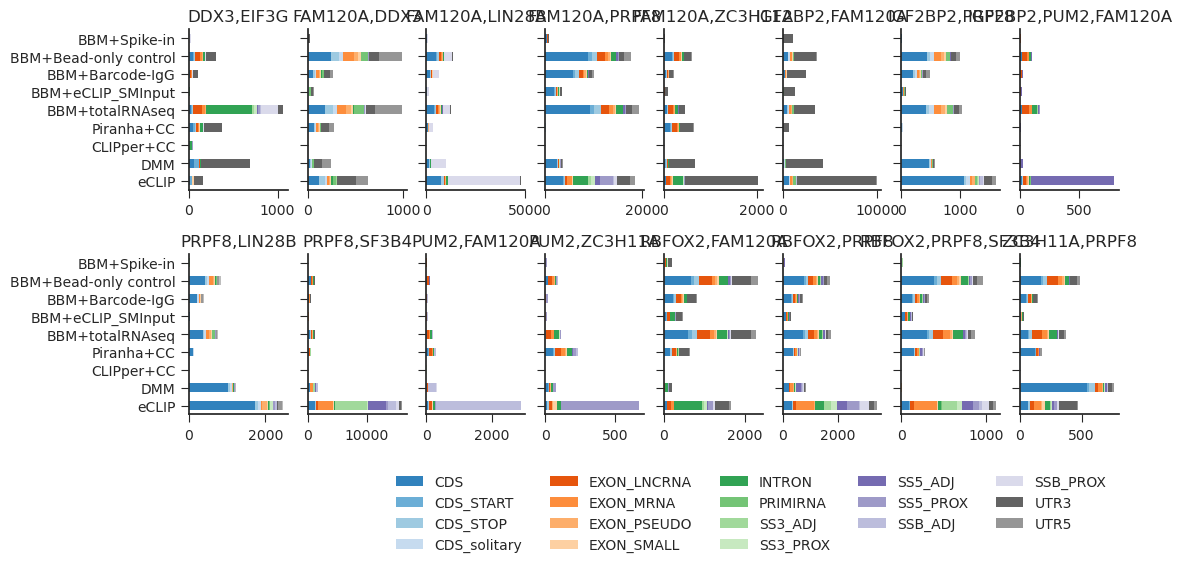

In [95]:

f, axes = plt.subplots(math.ceil(len(combinatorial)/8),8, figsize = (12,5), sharey = True)
axes = axes.flatten()
sns.set_palette('tab20c')
for ax, (name, group) in zip(axes, all_counts.groupby(by = 'pair')):
    
    if 'CDS_solitary' not in group.index:
        group.loc['CDS_solitary']=0
    group.sort_index().drop('pair', axis = 1).T.plot.barh(stacked = True, ax = ax, legend = False)
    ax.set_title(name)
    sns.despine()
    
    
ax.legend(bbox_to_anchor = (1, -0.3), ncol = 5)
plt.subplots_adjust(
                    hspace=0.4)
plt.tight_layout()

plt.savefig(figdir/f'combinatorial_feature_types.pdf')



In [96]:
all_counts.columns

Index(['eCLIP', 'DMM', 'CLIPper+CC', 'Piranha+CC', 'BBM+totalRNAseq',
       'BBM+eCLIP_SMInput', 'BBM+Barcode-IgG', 'BBM+Bead-only control',
       'BBM+Spike-in', 'pair'],
      dtype='object')

In [97]:
set(eclip_counts.columns)-set(all_counts.index)

{'RBP', 'name'}